# 过拟合与正则化 (From ``scratch``)

## 影响过拟合的因素

* **可调参数的数量**。当可调参数的数量(有时候也被称为自由度的数量)很大时，模型可能更加趋向于过拟合。
* **参数所取的值**。 当权重或偏置可以在一个很大的范围内取值时，模型更加趋向与过拟合。
* **训练样本的数量**。当训练样本极少时，即使你的模型很简单也很容易发生过拟合，但是如果你的数据集有数百万个样本，想要过拟合则需要一个更加灵活的模型。

之前在对手写数字进行分类时，我们并没有发生过拟合，因为我们的训练样本数远远超过了$784 \times 10 = 7840$加上$10$个偏差项，这使得我们的参数数量远远少于训练样本数，我们假设训练样本和参数数量差不多的情况开始来试错,并使用$l_2$正则化来避免过拟合以检验模型在测试集上的准确率。

In [1]:
import mxnet as mx
import numpy as np

from mxnet import gluon
from mxnet import nd
from mxnet import autograd

%matplotlib inline
import matplotlib as mlt
mlt.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

In [2]:
# test
mnist = mx.test_utils.get_mnist()
for k, v in mnist.items():
    print(k,":", v.shape)

train_label : (60000,)
test_data : (10000, 1, 28, 28)
test_label : (10000,)
train_data : (60000, 1, 28, 28)


## 加载数据集

In [3]:
num_inputs = 784
num_outputs = 10
num_examples = 1000
batch_size = 64

train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(mnist['train_data'][:num_examples].astype(np.float32),
                    mnist['train_label'][:num_examples].astype(np.float32)), batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(mnist['test_data'][:num_examples].astype(np.float32),
                    mnist['test_label'][:num_examples].astype(np.float32)), batch_size=batch_size, shuffle=True)

In [4]:
# test
for data, label in train_data:
    print(data.shape)
    print(label.shape)
    break

(64, 1, 28, 28)
(64,)


## 随机初始化参数

In [5]:
W = nd.random.normal(shape=(num_inputs, num_outputs))
b = nd.random.normal(shape=num_outputs)

params = [W, b]
for param in params:
    param.attach_grad()

In [6]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

## 定义模型和损失函数

In [7]:
def net(X):
    output = nd.dot(X, W) + b
    yprob = nd.softmax(output, axis=1)
    return yprob

def cross_entropy(yhat, y):
    return -nd.sum(y * nd.log(yhat + 1e-6))

In [8]:
# test
X = nd.random.normal(shape=(5,784))
yprob = net(X)
y = nd.arange(5)
yonehot = nd.one_hot(y, 10)
# print(yonehot)
# print(yprob)
# print(yonehot * nd.log(yprob + 1e-6))
# cross_entropy(yprob, yonehot)

## 定义评估函数

与前面不同的是，我们在评估函数里加入计算平均损失

In [9]:
def evaluate_accuracy(img_iter, net):
    numerator = .0
    denominator = .0
    loss_avg = .0
    for i, (data, label) in enumerate(img_iter):
        data = data.reshape((-1, 784))
        output = net(data)
        prediction = nd.argmax(output, axis=1)
        numerator += nd.sum(prediction == label)
        denominator += data.shape[0]
        # 计算Avg Loss
        label_one_hot = nd.one_hot(label, 10)
        loss = cross_entropy(output, label_one_hot)
        # moving avg loss(没怎么看懂)
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return (numerator / denominator).asscalar(), loss_avg

In [10]:
# test
evaluate_accuracy(train_data, net) 

(0.096000001, 553.29361152648937)

## 绘制损失和精度曲线

In [11]:
def ploting_curves(train_seq_loss, test_seq_loss, train_seq_acc, test_seq_acc):
    epoch = list(range(len(train_seq_loss)))
    fig = plt.figure(figsize=(20, 10))
    # If the three integers are I, J, and K, the subplot is the Ith plot on a grid with J rows and K columns.
    fig1 = fig.add_subplot(121)
    fig2 = fig.add_subplot(122)
    #
    fig1.set_title("Comparing Loss Functions")
    fig1.set_xlabel("epoch", fontsize=15)
    fig1.set_ylabel("Average Loss", fontsize=15)
#     fig1.semilogy(epoch, train_seq_loss)
#     fig1.semilogy(epoch, test_seq_loss)
    fig1.plot(epoch, train_seq_loss)
    fig1.plot(epoch, test_seq_loss)
    fig1.legend(["train_loss", "test_loss"], fontsize=15)
    fig1.grid(True, which="both")
    #
    fig2.set_title("Comparing Accuracy")
    fig2.set_xlabel("epoch", fontsize=15)
    fig2.set_ylabel("Accuracy", fontsize=15)
    fig2.plot(epoch, train_seq_acc)
    fig2.plot(epoch, test_seq_acc)
    fig2.legend(['train_acc', 'test_acc'], fontsize=15)
    fig2.grid(True, which="both")
    plt.show()

## 训练

In [12]:
epochs = 1000
learning_rate = .001
niter = 0 # 记录迭代轮数
moving_loss = .0
smoothing_constant = 0.01
 
train_seq_loss = []
test_seq_loss = []
train_seq_acc = []
test_seq_acc = []

for epoch in range(epochs):
    # total cumulative loss
    cumulative_loss = 0.0
    for i, (data, label) in enumerate(train_data):
        data = data.reshape((-1, 784))
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += nd.sum(loss).asscalar()
        
        # moving average loss 注意其写法
        niter += 1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss
        estmation_loss = moving_loss / (1-(1-smoothing_constant)**niter)
    
    test_acc, test_avg_loss = evaluate_accuracy(test_data, net)
    train_acc, train_avg_loss = evaluate_accuracy(train_data, net)
    
    train_seq_loss.append(train_avg_loss)
    test_seq_loss.append(test_avg_loss)
    train_seq_acc.append(train_acc)
    test_seq_acc.append(test_acc)
    
    if (epoch + 1) % 100 == 0:
        print("Epoch %s, MovingAvgTrain loss %s, Train avg loss %s,Test avg loss %s,Train acc %s, Test acc %s" % (epoch+1, estmation_loss, train_avg_loss, test_avg_loss, train_acc, test_acc))

Epoch 100, MovingAvgTrain loss 44.1552016002, Train avg loss 41.6273341179,Test avg loss 93.5980210304,Train acc 0.881, Test acc 0.716
Epoch 200, MovingAvgTrain loss 24.058211983, Train avg loss 23.2199248075,Test avg loss 79.0924932957,Train acc 0.944, Test acc 0.755
Epoch 300, MovingAvgTrain loss 16.1973365679, Train avg loss 15.8255484998,Test avg loss 74.4591853619,Train acc 0.967, Test acc 0.771
Epoch 400, MovingAvgTrain loss 12.4337608688, Train avg loss 12.1345677674,Test avg loss 71.7339980602,Train acc 0.982, Test acc 0.774
Epoch 500, MovingAvgTrain loss 9.76760872533, Train avg loss 9.63139554858,Test avg loss 69.3199338913,Train acc 0.989, Test acc 0.776
Epoch 600, MovingAvgTrain loss 8.12119516216, Train avg loss 7.96970178559,Test avg loss 68.2028303146,Train acc 0.991, Test acc 0.777
Epoch 700, MovingAvgTrain loss 7.04782643415, Train avg loss 7.05749291927,Test avg loss 67.5312798023,Train acc 0.993, Test acc 0.778
Epoch 800, MovingAvgTrain loss 6.65534850903, Train avg 

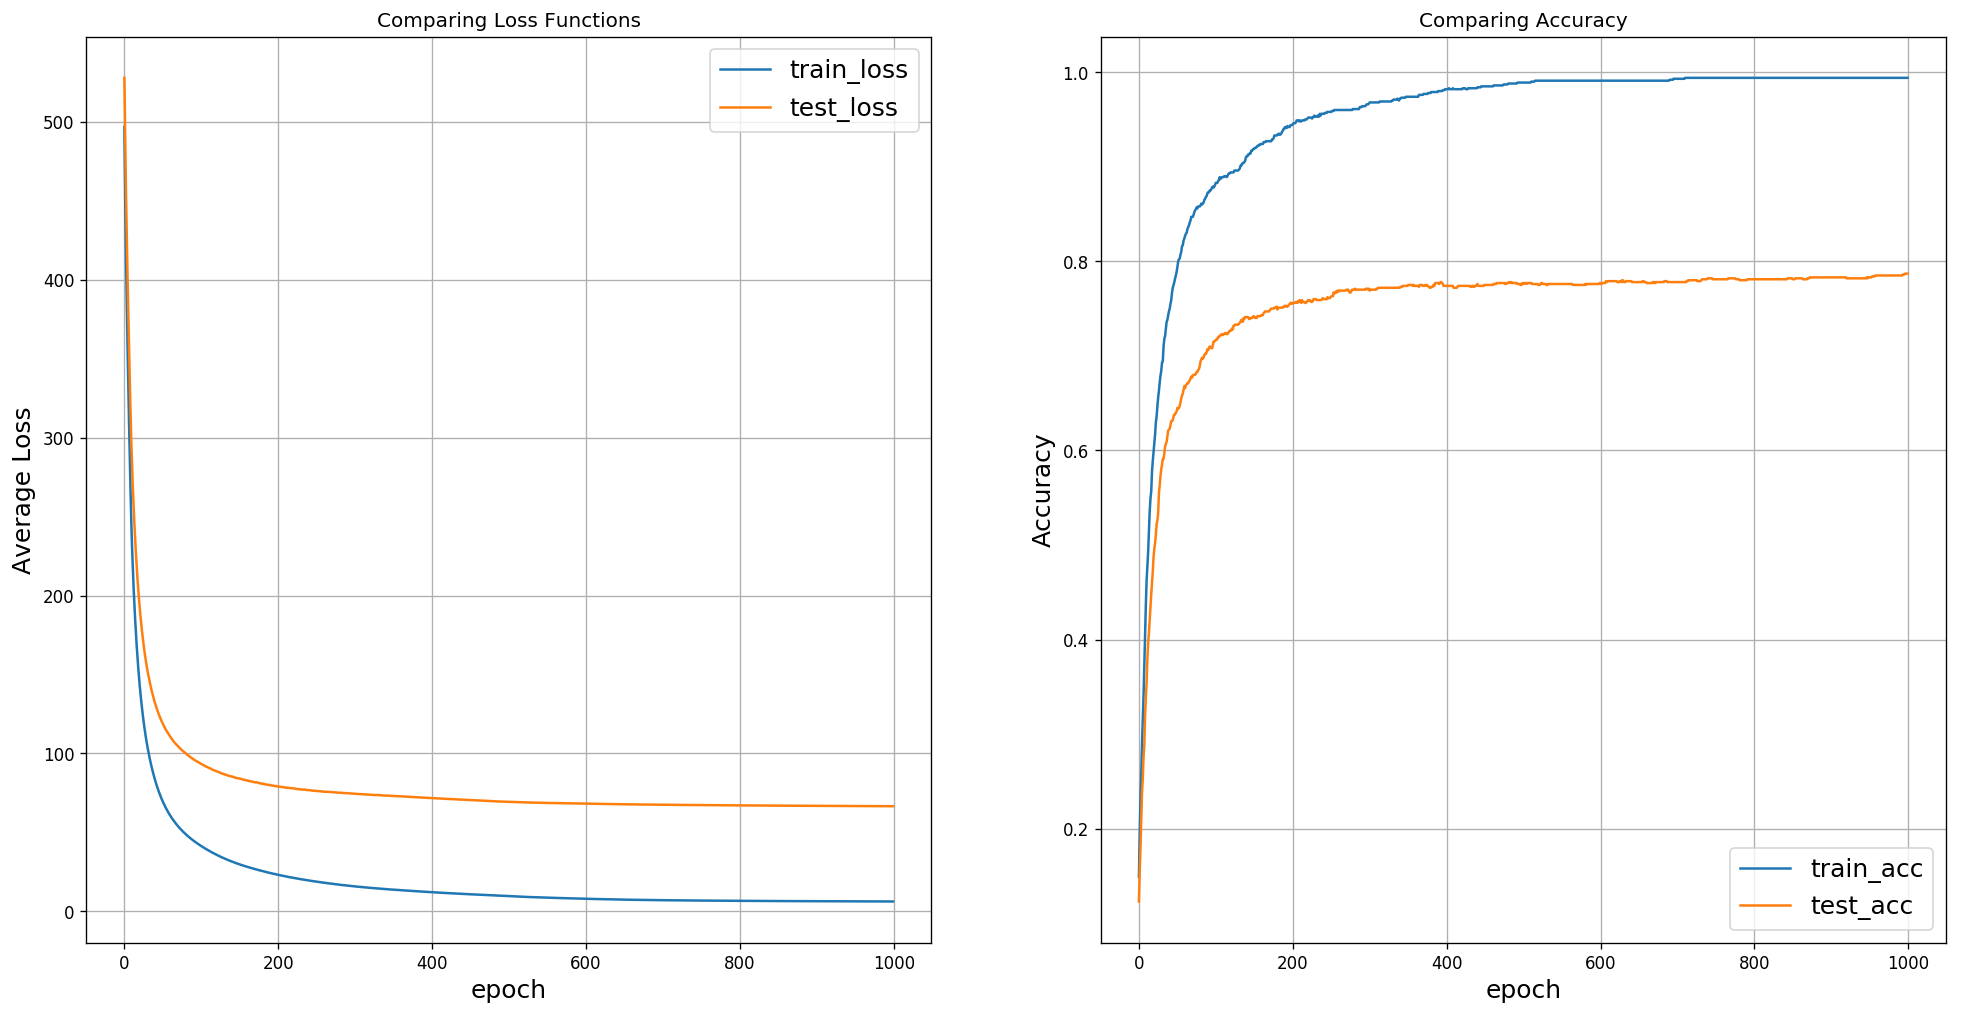

In [13]:
ploting_curves(train_seq_loss, test_seq_loss, train_seq_acc, test_seq_acc)

可以看到，我们的训练集的准确率已经到达了1，但是测试集的准确率只有不到0.8.这正是过拟合现象，因为我们有7000多参数量而只有1000个训练集，实际上有很多参数设置可以使得在训练集上达到100%的准确率。

## 正则化

其核心思想是：当模型过拟合时，其训练误差大大低于测试误差。我们已经在训练数据取得很好的效果，但是我们的测试数据表现还是有些不尽人意的地方。通常情况下，正则化技术试图折衷我们在训练集上的表现，以此换来降低我们的测试误差。

我们可以使用一些技术：我们可以使我们的模型不那么过于复杂，一种方法是降低可用参数的数量。例如，我们可以扔掉我们认为信息最少的输入特征的一部分（因此也就是相应的参数）。

另一种方法是限制我们权重可能的取值范围。一种方法是让权重取较小的值。我们可以通过改变我们的优化目标来惩罚我们的权重，一种常用的方法是$l_2$正则化。对于线性模型来说，即使在我们的模型被过度参数化的情况下，$l_@$正则化也会起到很好的效果。

$$\sum_{i}(\hat{y}-y)^2 + \lambda \| w \|^2_2$$

其中$\|w\|$是$l_2^2$范数，$\lambda$决定了我们把权重置为0的程度。

In [14]:
def l2_penalty(params):
    penalty = nd.zeros(shape=1)
    for param in params:
        penalty = penalty + nd.sum(param**2) #不能用+= 反向传播时不允许用这些符号
    return penalty

## 加入$l_2$正则化的模型训练

In [20]:
for param in params:
    param[:] = nd.random.normal(shape=param.shape)

In [21]:
epochs = 1000
niter = 0
learning_rate = .001

moving_loss = .0
smoothing_constant = 0.1
l2_weight_decay = 0.1

train_seq_loss = []
test_seq_loss = []
train_seq_acc = []
test_seq_acc = []

for epoch in range(epochs):
    cumulative_loss = .0
    for i, (data, label) in enumerate(train_data):
        data = data.reshape((-1, 784))
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot) + l2_weight_decay * l2_penalty(params)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += nd.sum(loss).asscalar()
          
        # moving average loss
        niter += 1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss
        estimate_loss = moving_loss / (1-(1-smoothing_constant)**niter)
    
    train_acc, train_avg_loss = evaluate_accuracy(train_data, net)
    test_acc, test_avg_loss = evaluate_accuracy(test_data, net)
    
    train_seq_loss.append(train_avg_loss)
    test_seq_loss.append(test_avg_loss)
    train_seq_acc.append(train_acc)
    test_seq_acc.append(test_acc)
            
    if (epoch + 1) % 100 == 0:
        print("Epoch %s, MovingAvgTrain loss %s, Train avg loss %s,Test avg loss %s,Train acc %s, Test acc %s" % (epoch+1, estimate_loss, train_avg_loss, test_avg_loss, train_acc, test_acc))      

Epoch 100, MovingAvgTrain loss 431.299851442, Train avg loss 29.1985256672,Test avg loss 71.5120921135,Train acc 0.886, Test acc 0.714
Epoch 200, MovingAvgTrain loss 225.285749817, Train avg loss 12.7946335375,Test avg loss 47.0989837646,Train acc 0.964, Test acc 0.784
Epoch 300, MovingAvgTrain loss 123.854230469, Train avg loss 9.1030869782,Test avg loss 38.2480602264,Train acc 0.986, Test acc 0.805
Epoch 400, MovingAvgTrain loss 71.5077940268, Train avg loss 8.24562349916,Test avg loss 34.2310259342,Train acc 0.989, Test acc 0.823
Epoch 500, MovingAvgTrain loss 45.1773990458, Train avg loss 8.05515724421,Test avg loss 32.3610430956,Train acc 0.99, Test acc 0.833
Epoch 600, MovingAvgTrain loss 31.2125241597, Train avg loss 8.03435912728,Test avg loss 31.5840004683,Train acc 0.992, Test acc 0.843
Epoch 700, MovingAvgTrain loss 24.1160130666, Train avg loss 8.04678761959,Test avg loss 31.2442438006,Train acc 0.992, Test acc 0.841
Epoch 800, MovingAvgTrain loss 20.2712854781, Train avg l

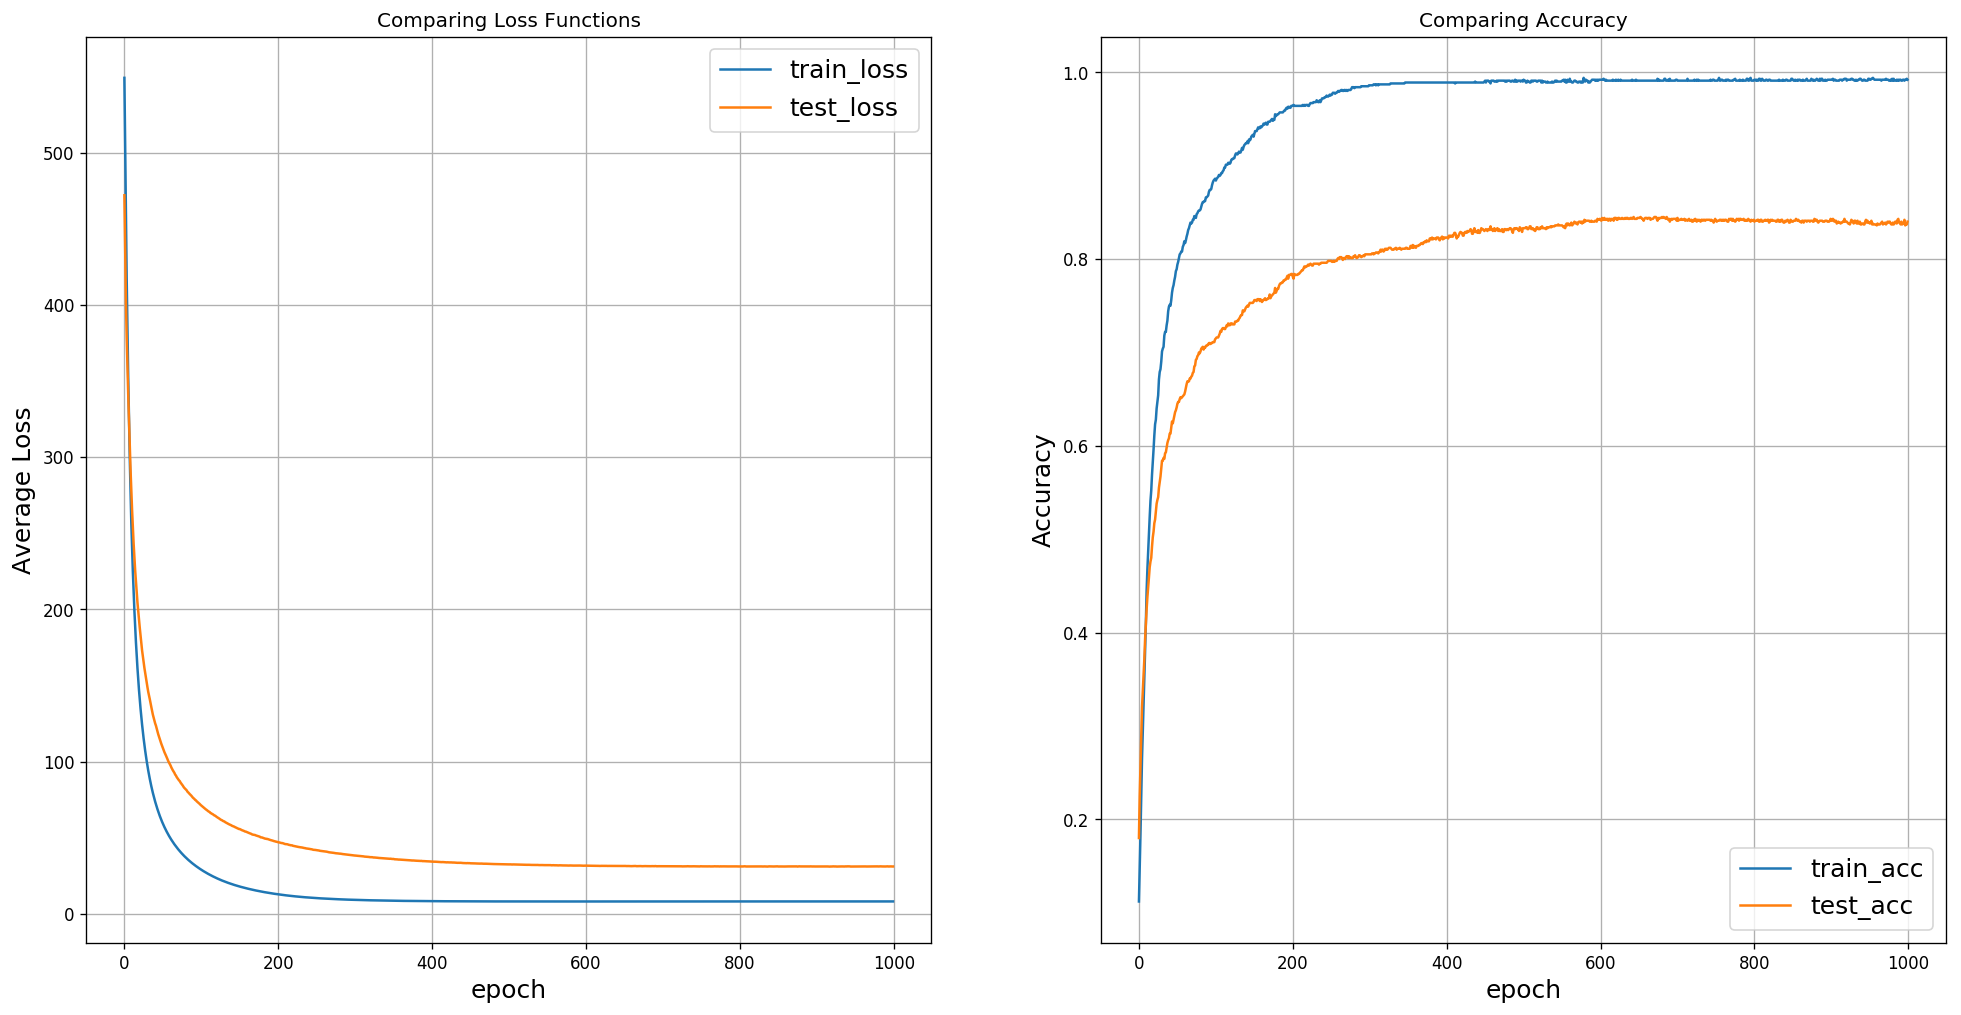

In [22]:
ploting_curves(train_seq_loss, test_seq_loss, train_seq_acc, test_seq_acc)

可以看到$l_2$正则化确实提升了模型的效果，通常我们会认为较小的权重是好的，我们还有更多的方法来约束权重的值：

* 当需要使得权重的总和很小时，我们是用$L_1$正则化，通过施加罚项$\sum_i |w_i|$.
* 当需要最大的权重不至于过大时，我们通过最大范数约束$L_\infty$来进行约束，通过施加罚项$\max_i |w_i|$.
* 当需要使得非零权重的数量很少时，即权重向量$W$是稀疏的，我们可以通过$L_0$范数来解决，即$\sum_i I\{w_i \neq 0\}$，但$L_0$范数是非光滑的(non-smooth)，我们可以通过$L_1$范数来近似解决这个问题。